<a href="https://colab.research.google.com/github/tushar12345/Data-Science-Projects/blob/master/Movie_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#Movie REcommendation system
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Embedding, Flatten, Dropout, Dense , Dot, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder 

In [16]:
#download data , ! sign is used to run shell commnands
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2020-04-30 16:57:58--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.1’

ml-latest-small.zip 100%[===================>] 955.28K  1.53MB/s    in 0.6s    

2020-04-30 16:57:59 (1.53 MB/s) - ‘ml-latest-small.zip.1’ saved [978202/978202]



In [17]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
replace ml-latest-small/links.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [18]:
movies =pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [19]:
len(movies)

9742

In [0]:
ratings=pd.read_csv('ml-latest-small/ratings.csv')

In [21]:
print(ratings.tail(10))
print(len(ratings))

        userId  movieId  rating   timestamp
100826     610   162350     3.5  1493849971
100827     610   163937     3.5  1493848789
100828     610   163981     3.5  1493850155
100829     610   164179     5.0  1493845631
100830     610   166528     4.0  1493879365
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415
100836


In [0]:
#join rating with movie as MovieId is the primary key
ratings =ratings.merge(movies, on='movieId').drop(['timestamp','genres'],axis=1)


In [23]:
ratings.head(20)

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)
5,18,1,3.5,Toy Story (1995)
6,19,1,4.0,Toy Story (1995)
7,21,1,3.5,Toy Story (1995)
8,27,1,3.0,Toy Story (1995)
9,31,1,5.0,Toy Story (1995)


Generate Sequential Identifiers

userId and movieId are not sequential, which causes problems for our model. To compensate, we can use the LabelEncoder class from scikit-learn to generate sequential identifiers for users and movies. 
The original identifiers are still available, so we can always join back to the original data set if needed.

In [24]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc=LabelEncoder()
ratings['movieSeq']=item_enc.fit_transform(ratings['movieId'].values)

#ratings =ratings.drop(['userSeq1'],axis=1)
ratings.head(10)

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0
5,18,1,3.5,Toy Story (1995),17,0
6,19,1,4.0,Toy Story (1995),18,0
7,21,1,3.5,Toy Story (1995),20,0
8,27,1,3.0,Toy Story (1995),26,0
9,31,1,5.0,Toy Story (1995),30,0


In [25]:
train_unnused , test= train_test_split(ratings,test_size = 0.20, random_state =0)

# All data is used for training
train = ratings

numUsers = len(train.userSeq.unique())
numMovies = len(train.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(100836, 20168)


In [26]:
numFeatures = 50
dropout = 0.0

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        30500       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        486200      input_4[0][0]                    
____________________________________________________________________________________________

Epoch 1/10
3152/3152 [==============================] - 26s 8ms/step - loss: 6.3157 - val_loss: 1.4770
Epoch 2/10
3152/3152 [==============================] - 26s 8ms/step - loss: 1.1505 - val_loss: 0.7990
Epoch 3/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.8042 - val_loss: 0.6317
Epoch 4/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.6614 - val_loss: 0.5228
Epoch 5/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.5528 - val_loss: 0.4364
Epoch 6/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.4627 - val_loss: 0.3670
Epoch 7/10
3152/3152 [==============================] - 25s 8ms/step - loss: 0.3874 - val_loss: 0.3009
Epoch 8/10
3152/3152 [==============================] - 26s 8ms/step - loss: 0.3213 - val_loss: 0.2490
Epoch 9/10
3152/3152 [==============================] - 25s 8ms/step - loss: 0.2652 - val_loss: 0.1991
Epoch 10/10
3152/3152 [==============================] - 25s 8ms/step - l

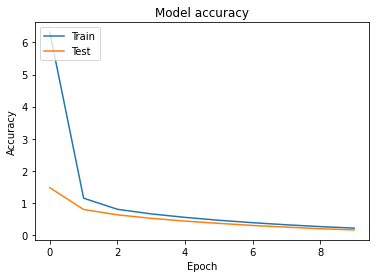

In [27]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()